<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew.

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [234]:
#Importing clean titanic dataset as a result of EDA in Lab 2.2.1.
titanic = pd.read_csv(r'/Users/annaxu/Documents/Data Science/DATA/titanic_train - Cleaned.csv', index_col=0).set_index('PassengerId')
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_group
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,G
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,F
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,E


Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`.

In [60]:
titanic.corr(numeric_only=True)['Survived']

Unnamed: 0   -0.005007
Survived      1.000000
Pclass       -0.338481
Age          -0.064910
SibSp        -0.035322
Parch         0.081629
Fare          0.257307
Name: Survived, dtype: float64

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [104]:
feature_cols = ['Pclass', 'Parch']
Y = titanic['Survived']
X = titanic[feature_cols]

#### 3.2 Split

Split the data into training and testing subsets:

- Use `random_state` = 1

In [108]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [111]:
model = LogisticRegression()

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [114]:
model.fit(X_train, Y_train)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [117]:
model.coef_

array([[-0.87255641,  0.33795155]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [120]:
model.intercept_

array([1.30477093])

We can create tuples of the predictor names and coefficients like this:

In [123]:
print(set(zip(feature_cols, model.coef_[0])))

{('Parch', 0.3379515495980988), ('Pclass', -0.8725564114352725)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [125]:
for col in zip(X_train.columns, model.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.872556
Parch       +0.337952


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The accuracy `score` is the proportion of correct predictions:

In [132]:
model.score(X_train, Y_train)

0.6901197604790419

What is the accuracy `score` for the test data?

In [136]:
model.score(X_test, Y_test)

0.6681614349775785

What can we say about this result?

ANSWER
- The model has a 65 - 70% accuracy in predicting the outcome.
- The scores are similar between train and test datasets so overfitting is unlikely.

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [145]:
feature_cols = ['Pclass', 'Parch', 'Age']
Y = titanic['Survived']
X = titanic[feature_cols]

In [160]:
# Build Model
model = LogisticRegression()
# Fit Model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)
model.fit(X_train, Y_train)
# Score
print("Accuracy score on training data: " + str(round(model.score(X_train, Y_train), 3)))
print("Accuracy score on test data: " + str(round(model.score(X_test, Y_test), 3)))

Accuracy score on training data: 0.717
Accuracy score on test data: 0.673


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- Age is probably uncorrelated with survival.
- Age might not be independent of the other features.
- Maybe filling nulls with median age affected the correlation.

Let's see where the model is going wrong by showing the Confusion Matrix:

In [175]:
from sklearn import metrics
y_pred_class = model.predict(X_test)
print(metrics.confusion_matrix(Y_test, y_pred_class))

[[107  21]
 [ 52  43]]


Nb. Here is how `confusion_matrix` arranges its output:

In [177]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: 

TN - The model correctly predicted 107 passengers did not survive.
FP - The model incorrectly predicted 21 passengers did survive. 
FN - The model incorrectly predicted 52 passengers did not survive. 
TP - The model correctly predicted 43 passengers did survive.

FN is more the prevalent error.

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

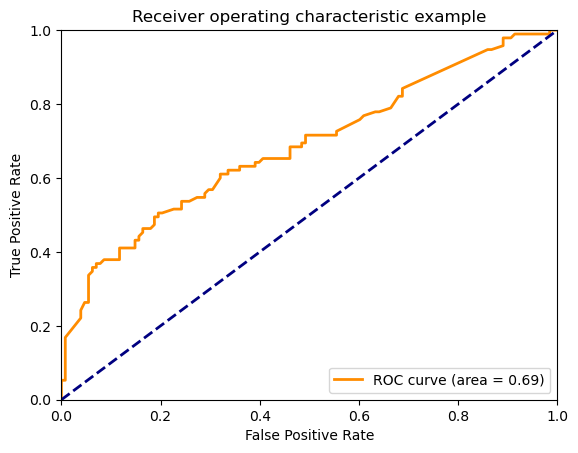

In [191]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Interpretting the ROC curve:
- The diagonal line represents random chance.
- A ROC curve below the diagonal line means the model gives more FPs than TPs and is worse than random chance. That's bad!
- A ROC curve closest to True Positive Rate = 1 is optimal.
- Area under the ROC curve of 0.69 represents a good model.


### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [236]:
dummies = pd.get_dummies(titanic[['Sex', 'Embarked']]).astype(int)
titanic_with_dummies = pd.concat([titanic, dummies], axis=1)
titanic_with_dummies.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_group,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,G,0,1,0,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,1,0,1,0,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,F,1,0,0,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,1,0,0,0,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,E,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first variable from each captures two possible states.)

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [280]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

feature_cols = ['Pclass', 'Parch', 'Age', 'SibSp', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
Y = titanic_with_dummies['Survived']
X = titanic_with_dummies[feature_cols]

model = LogisticRegression()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)
model.fit(X_train, Y_train)
print("Accuracy score on training data: " + str(round(model.score(X_train, Y_train), 3)))
print("Accuracy score on test data: " + str(round(model.score(X_test, Y_test), 3)))

Accuracy score on training data: 0.808
Accuracy score on test data: 0.798


Plot the ROC curve for the new model:

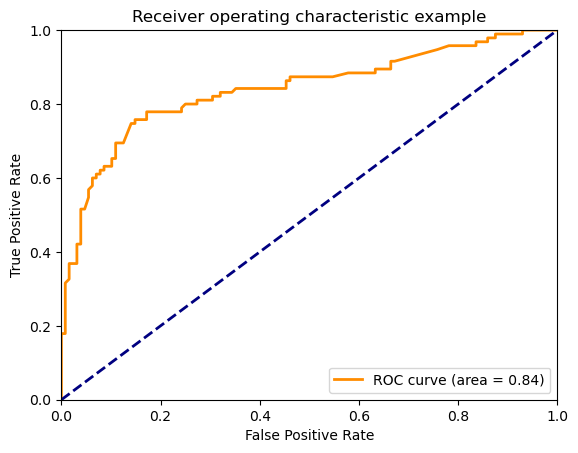

In [243]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Can we improve the model by including the remaining features?

Yes, the area under the ROC curve improved from 0.69 to 0.84 which means the model was able to predict more TPs.

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

In [317]:
feature_cols = ['Pclass', 'Parch', 'Age', 'SibSp', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
Y = titanic_with_dummies['Survived']
X = titanic_with_dummies[feature_cols]

model = LogisticRegression()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
model.fit(X_train, Y_train)
print("Accuracy score on training data: " + str(round(model.score(X_train, Y_train), 3)))
print("Accuracy score on test data: " + str(round(model.score(X_test, Y_test), 3)))

Accuracy score on training data: 0.807
Accuracy score on test data: 0.816


In [326]:
#High C = Higher weight to the training data
#Low C = Higher weight to the complexity penalty

from sklearn.model_selection import cross_val_score

#Uncontrolled
model1 = LogisticRegression(C=10)
scores1 = cross_val_score(model1, X, Y, cv=5) #dataset is split into 5 parts

#Controlled
model2 = LogisticRegression() #default is C = 1
scores2 = cross_val_score(model2, X, Y, cv=5) #dataset is split into 5 parts

print("Accuracy with uncontrolled overfitting: " + str(round(scores1.mean(), 3)))
print("Accuracy with controlled overfitting: " + str(round(scores2.mean(), 3)))

Accuracy with uncontrolled overfitting: 0.791
Accuracy with controlled overfitting: 0.79


In [328]:
#Accuracy decreased when controlled overfitting which can happen because we are sacrificing some of the model's capacity to perfectly fit the training data. 

In [330]:
#fpr = false positive rate
#tpr = true positive rate
#Take "model" as the best model.

preds = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
print("FPR:", fpr)
print("TPR:", tpr)

FPR: [0.         0.         0.00787402 0.00787402 0.00787402 0.00787402
 0.01574803 0.01574803 0.02362205 0.02362205 0.02362205 0.02362205
 0.03149606 0.03149606 0.03937008 0.03937008 0.06299213 0.07874016
 0.08661417 0.09448819 0.09448819 0.1023622  0.1023622  0.11023622
 0.12598425 0.13385827 0.13385827 0.14173228 0.14173228 0.16535433
 0.16535433 0.17322835 0.17322835 0.20472441 0.20472441 0.21259843
 0.21259843 0.21259843 0.23622047 0.23622047 0.24409449 0.24409449
 0.27559055 0.29133858 0.2992126  0.31496063 0.34645669 0.37007874
 0.37007874 0.39370079 0.41732283 0.43307087 0.49606299 0.50393701
 0.51968504 0.51968504 0.52755906 0.52755906 0.5511811  0.55905512
 0.56692913 0.59055118 0.61417323 0.61417323 0.62992126 0.63779528
 0.65354331 0.66929134 0.66929134 0.68503937 0.7007874  0.70866142
 0.70866142 0.81102362 0.81102362 0.81889764 0.83464567 0.8976378
 0.90551181 0.92125984 0.93700787 0.95275591 0.95275591 1.        ]
TPR: [0.         0.01041667 0.01041667 0.20833333 0.25   

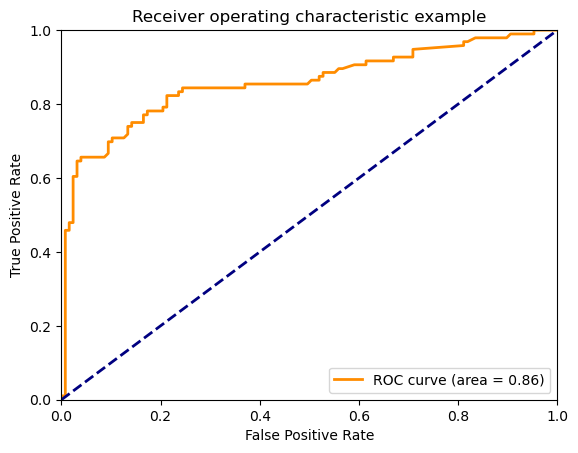

In [333]:
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()



---



---



> > > > > > > > > © 2025 Institute of Data


---



---



